In [66]:
# src: https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

## Loading the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/BT4222/data/cleaned_mbs_reviews.csv')
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...


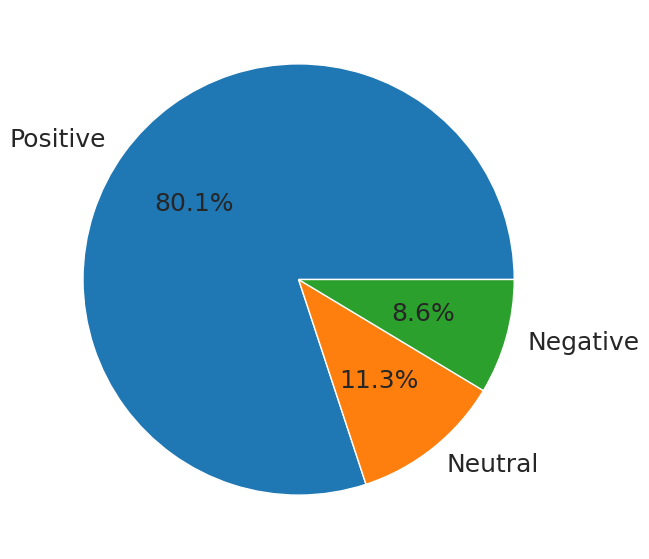

In [8]:
plt.pie(data['label'].value_counts(), labels=data['label'].unique().tolist(), autopct='%1.1f%%')
plt.show()

In [20]:
# combine raw title and review
def combine(r):
  return str(r['review_title']) + " " + str(r['review_text'])

In [21]:
data["combined_review"] = data.apply(lambda row: combine(row), axis = 1)

In [22]:
data.head(3)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,Length,combined_review
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,787,"Sick in Singapore, and MBS staff were amazing!..."
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,785,Lovely place to go whatever you plan to do! Wh...
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,784,Thank you for the unforgettable memories I sta...


## Exploratory Data Analysis

### Counts and Length:
Start by checking how long the reviews are
* Character count
* Word count
* Mean word length
* Mean sentence length

In [23]:
length = len(data['combined_review'][0])
print(f'Length of a sample review: {length}')

Length of a sample review: 834


In [24]:
data['Length'] = data['combined_review'].str.len()
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,Length,combined_review
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,834,"Sick in Singapore, and MBS staff were amazing!..."
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,829,Lovely place to go whatever you plan to do! Wh...
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,825,Thank you for the unforgettable memories I sta...
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,562,Amazing hotel but not sure I’d do it again We ...
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,836,Stunning hotel and overall an amazing experien...
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...,384,Perfect stay! One of the best hotels we stayed...
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...,692,A memorable experience Our experience at Marin...
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...,237,Beyond infinity Breathtaking garden view plus ...
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...,853,Disappointing but still worth it for the iconi...
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...,679,Exceptional The hotel itself is amazing and th...


#### **Word Count**: Number of words in a review

In [25]:
word_count = data['combined_review'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

Word count in a sample review: 155


In [26]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [27]:
data['Word_count'] = data['combined_review'].apply(word_count)
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,Length,combined_review,Word_count
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,834,"Sick in Singapore, and MBS staff were amazing!...",155
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,829,Lovely place to go whatever you plan to do! Wh...,157
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,825,Thank you for the unforgettable memories I sta...,146
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,562,Amazing hotel but not sure I’d do it again We ...,110
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,836,Stunning hotel and overall an amazing experien...,151
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...,384,Perfect stay! One of the best hotels we stayed...,65
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...,692,A memorable experience Our experience at Marin...,120
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...,237,Beyond infinity Breathtaking garden view plus ...,36
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...,853,Disappointing but still worth it for the iconi...,156
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...,679,Exceptional The hotel itself is amazing and th...,121


#### **Mean word length**: Average length of words

In [28]:
data['mean_word_length'] = data['combined_review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,Length,combined_review,Word_count,mean_word_length
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,834,"Sick in Singapore, and MBS staff were amazing!...",155,4.367742
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,829,Lovely place to go whatever you plan to do! Wh...,157,4.248408
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,825,Thank you for the unforgettable memories I sta...,146,4.643836
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,562,Amazing hotel but not sure I’d do it again We ...,110,4.118182
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,836,Stunning hotel and overall an amazing experien...,151,4.536424
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...,384,Perfect stay! One of the best hotels we stayed...,65,4.923077
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...,692,A memorable experience Our experience at Marin...,120,4.758333
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...,237,Beyond infinity Breathtaking garden view plus ...,36,5.555556
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...,853,Disappointing but still worth it for the iconi...,156,4.467949
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...,679,Exceptional The hotel itself is amazing and th...,121,4.611570


#### **Mean sentence length**: Average length of the sentences in the review

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['combined_review'][0])])

103.25

In [32]:
data['mean_sent_length'] = data['combined_review'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
data.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,Length,combined_review,Word_count,mean_word_length,mean_sent_length
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,834,"Sick in Singapore, and MBS staff were amazing!...",155,4.367742,103.250000
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,829,Lovely place to go whatever you plan to do! Wh...,157,4.248408,67.666667
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,825,Thank you for the unforgettable memories I sta...,146,4.643836,116.857143
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,562,Amazing hotel but not sure I’d do it again We ...,110,4.118182,61.555556
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,836,Stunning hotel and overall an amazing experien...,151,4.536424,75.181818
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...,384,Perfect stay! One of the best hotels we stayed...,65,4.923077,54.142857
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...,692,A memorable experience Our experience at Marin...,120,4.758333,75.777778
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...,237,Beyond infinity Breathtaking garden view plus ...,36,5.555556,77.666667
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...,853,Disappointing but still worth it for the iconi...,156,4.467949,84.400000
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...,679,Exceptional The hotel itself is amazing and th...,121,4.611570,74.444444


In [44]:
def visualize(col):

    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=data[col], hue=data['label'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    sns.kdeplot(data = data, x = col, hue='label')
    plt.legend(data['label'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

In [45]:
data.columns

Index(['Unnamed: 0', 'date_of_stay', 'traveller_username', 'review_title',
       'review_text', 'travel_type', 'traveller_country_origin',
       'traveller_total_contributions',
       'traveller_total_helpful_contributions', 'rating1', 'rating2', 'rating',
       'valid_rating', 'label', 'cleaned_review', 'Length', 'combined_review',
       'Word_count', 'mean_word_length', 'mean_sent_length'],
      dtype='object')

Length



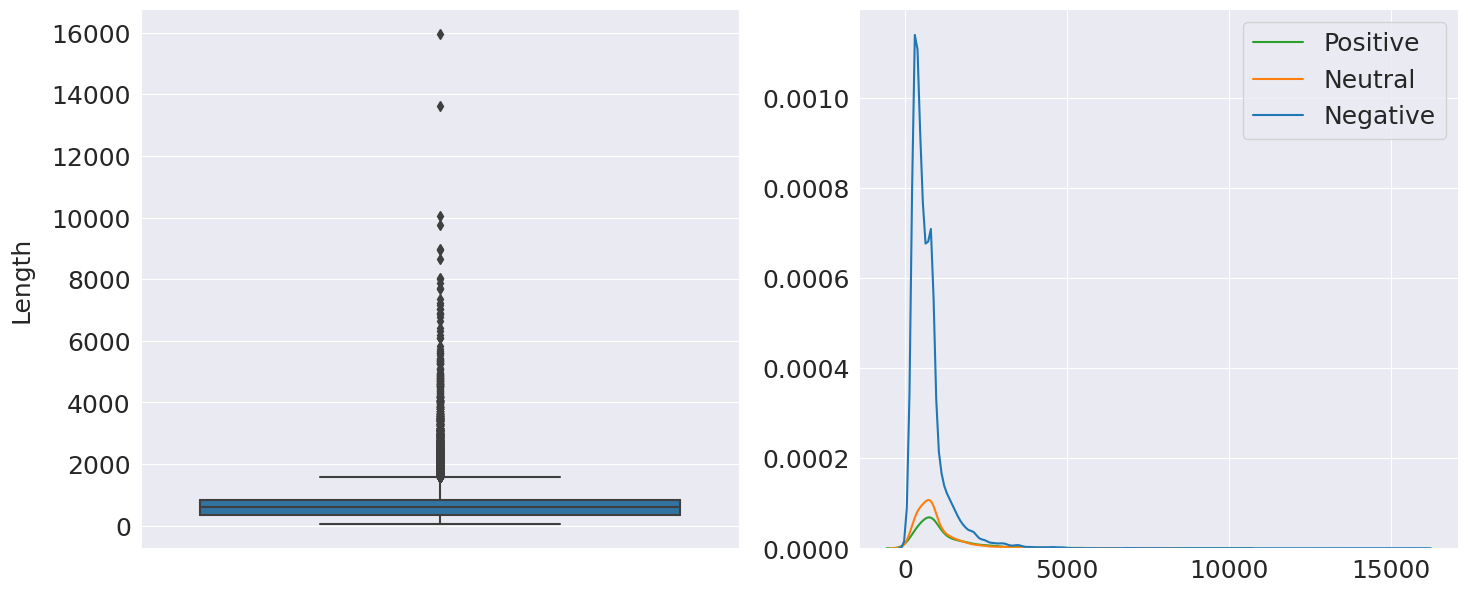

Word_count



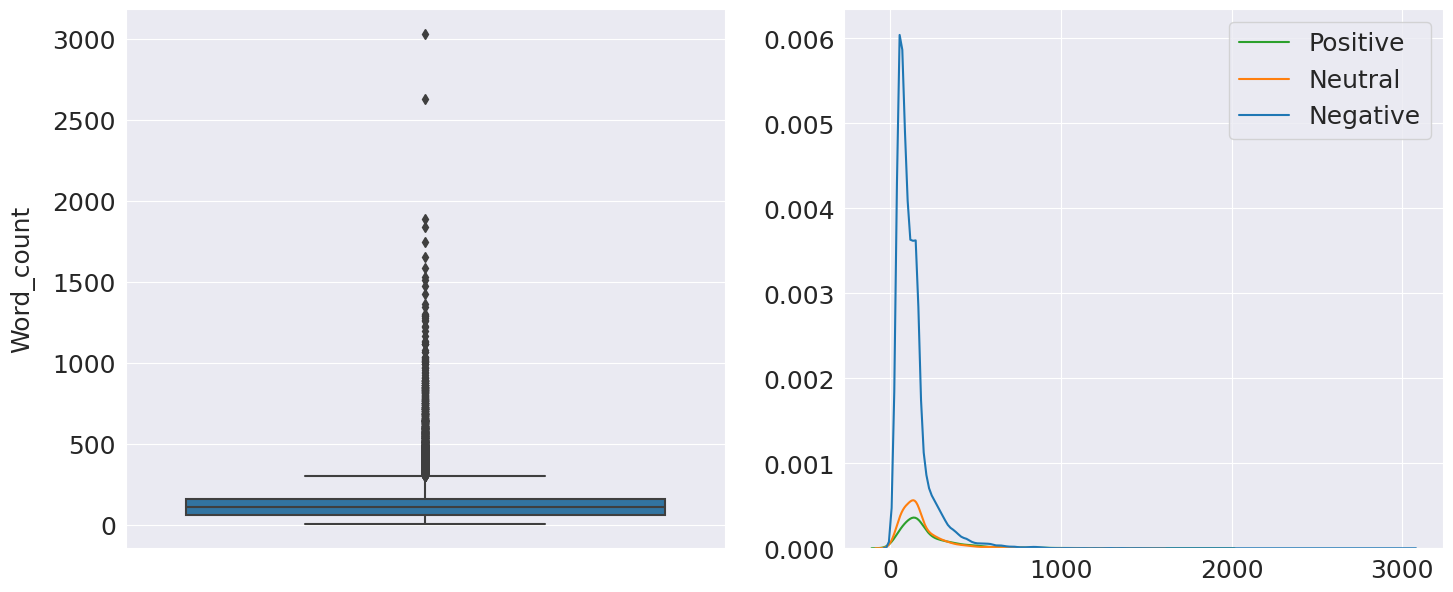

mean_word_length



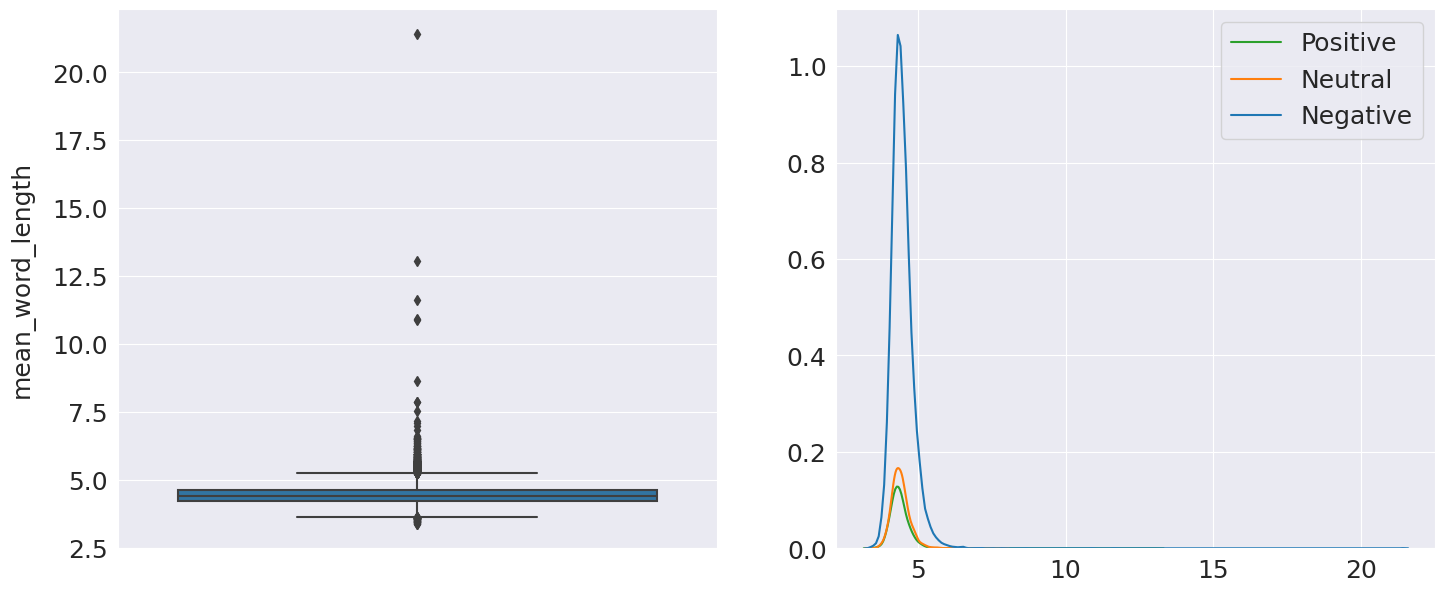

mean_sent_length



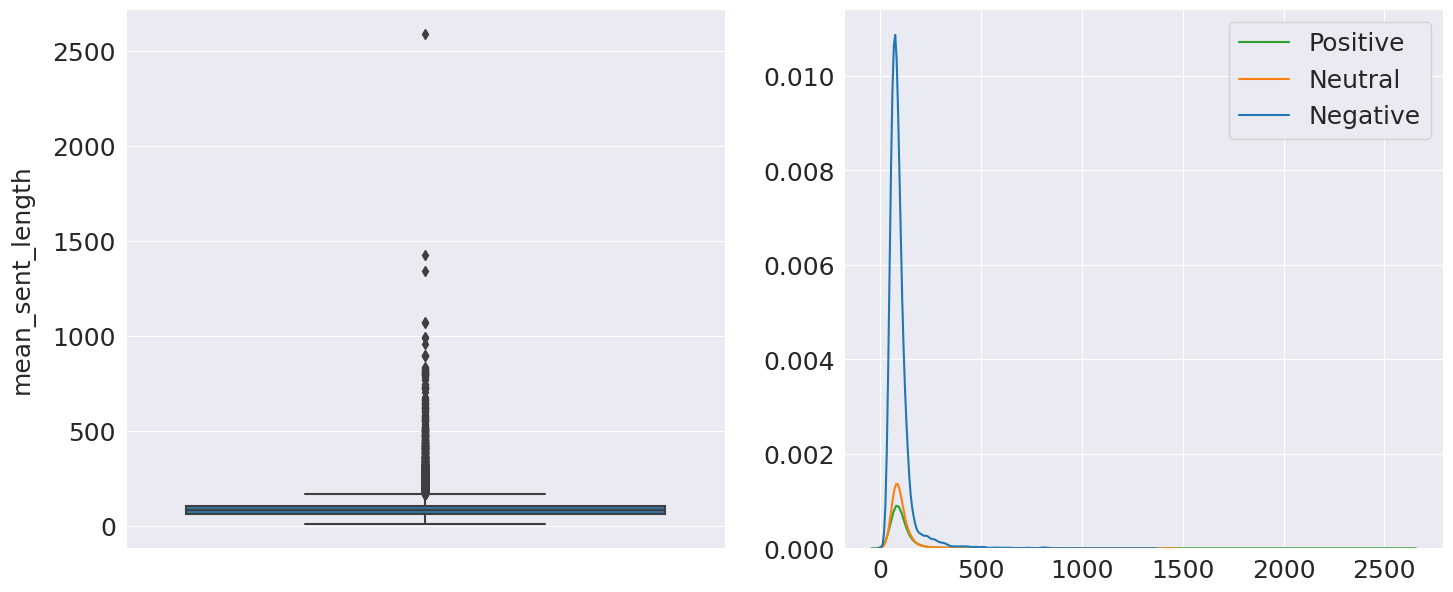

In [46]:
features = ['Length', 'Word_count', 'mean_word_length', 'mean_sent_length']
for feature in features:
    print(feature)
    visualize(feature)

## Term Frequency Analysis
Examining the most frequently occuring words is one of the most popular systems of Text analytics. For example, in a sentiment analysis problem, a positive text is bound to have words like 'good', 'great', 'nice', etc. more in number than other words that imply otherwise.

*Note*: Term Frequencies are more than counts and lenghts, so the first requirement is to preprocess the text

In [47]:
df = data.drop(features, axis=1)
df.head()

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,"Sick in Singapore, and MBS staff were amazing!..."
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,Lovely place to go whatever you plan to do! Wh...
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,Thank you for the unforgettable memories I sta...
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,Amazing hotel but not sure I’d do it again We ...
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,Stunning hotel and overall an amazing experien...


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19371 entries, 0 to 19370
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             19371 non-null  int64  
 1   date_of_stay                           18822 non-null  object 
 2   traveller_username                     19371 non-null  object 
 3   review_title                           19370 non-null  object 
 4   review_text                            19371 non-null  object 
 5   travel_type                            12198 non-null  object 
 6   traveller_country_origin               17237 non-null  object 
 7   traveller_total_contributions          19365 non-null  float64
 8   traveller_total_helpful_contributions  18055 non-null  float64
 9   rating1                                14743 non-null  float64
 10  rating2                                4627 non-null   float64
 11  ra

There is no missing data, therefore, we can move to the next stage. For Term frequency analysis, it is essential that the text data be preprocessed.
* Lowercase
* Remove punctutations
* Stopword removal

In [49]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
df['combined_review'] = df['combined_review'].apply(clean)
df.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,sick singapore mbs staff amazing singapore bus...
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,lovely place go whatever plan whether soak mar...
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,thank unforgettable memories stayed marina bay...
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,amazing hotel sure id stayed one night hotel g...
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,stunning hotel overall amazing experience retu...
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...,perfect stay one best hotels stayed great envi...
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...,memorable experience experience marina bay san...
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...,beyond infinity breathtaking garden view plus ...
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...,disappointing still worth iconic pool experien...
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...,exceptional hotel amazing rooms fabulous main ...


In [53]:
df['combined_review'][0]

'sick singapore mbs staff amazing singapore business unfortunately ended stay room several days got sick result became intimate familiar room moreso wouldve liked luckily room nice balcony comfy bed spent tons time staff also amazing brought anything everything asked tons water bottles food kleenex humidifier etc could get well even came room refill humidifier upon request depressing sick away home well looked mbs staff catered made unfortunate circumstance much tolerable thank great job making'

In [54]:
def corpus(text):
    text_list = text.split()
    return text_list

In [55]:
df['Review_lists'] = df['combined_review'].apply(corpus)
df.head(10)

,Unnamed: 0,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review,combined_review,Review_lists
0,0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunat...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore b...,sick singapore mbs staff amazing singapore bus...,"[sick, singapore, mbs, staff, amazing, singapo..."
1,1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,Whether it’s to soak up the Marina Bay citysca...,NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak mar...,lovely place go whatever plan whether soak mar...,"[lovely, place, go, whatever, plan, whether, s..."
2,2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,I stayed at Marina Bay Sands to propose to my ...,Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay s...,thank unforgettable memories stayed marina bay...,"[thank, unforgettable, memories, stayed, marin..."
3,3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good par...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good...,amazing hotel sure id stayed one night hotel g...,"[amazing, hotel, sure, id, stayed, one, night,..."
4,4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,We have just returned from a super couple of d...,Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience retu...,stunning hotel overall amazing experience retu...,"[stunning, hotel, overall, amazing, experience..."
5,5,Date of stay: September 2023,Ingo S,Perfect stay!,One of the best hotels we stayed! Great enviro...,Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environ...,perfect stay one best hotels stayed great envi...,"[perfect, stay, one, best, hotels, stayed, gre..."
6,6,Date of stay: August 2023,Anca23,A memorable experience,Our experience at Marina Bay Sands was wonderf...,Trip type: Travelled with family,"Bucharest, Romania",11.0,1.0,NaN,5.0,5.0,True,Positive,memorable experience experience marina bay san...,memorable experience experience marina bay san...,"[memorable, experience, experience, marina, ba..."
7,7,Date of stay: August 2023,영준 표,Beyond infinity,Breathtaking garden view plus fascinating infi...,Trip type: Travelled with family,NaN,1.0,NaN,NaN,5.0,5.0,True,Positive,beyond infinity breathtaking garden view plus ...,beyond infinity breathtaking garden view plus ...,"[beyond, infinity, breathtaking, garden, view,..."
8,8,Date of stay: August 2023,beachbabyJersey,Disappointing but still worth it for the iconi...,"Honestly, we were pretty disappointed with our...",Trip type: Travelled with family,Nottingham,202.0,89.0,3.0,NaN,3.0,True,Neutral,disappointing still worth iconic pool experien...,disappointing still worth iconic pool experien...,"[disappointing, still, worth, iconic, pool, ex..."
9,9,Date of stay: August 2023,Kristine M,Exceptional,The hotel itself is amazing and the rooms are ...,Trip type: Travelled as a couple,Napier,12.0,2.0,5.0,NaN,5.0,True,Positive,exceptional hotel amazing room fabulous main f...,exceptional hotel amazing rooms fabulous main ...,"[exceptional, hotel, amazing, rooms, fabulous,..."


In [56]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['Review_lists'][i]
len(corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 19371/19371 [00:00<00:00, 51360.71it/s]


1407395

In [57]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('hotel', 32911),
 ('room', 25651),
 ('pool', 24584),
 ('view', 14123),
 ('stay', 12413),
 ('great', 10800),
 ('singapore', 10431),
 ('bay', 10371),
 ('service', 10098),
 ('one', 9525)]

In [58]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

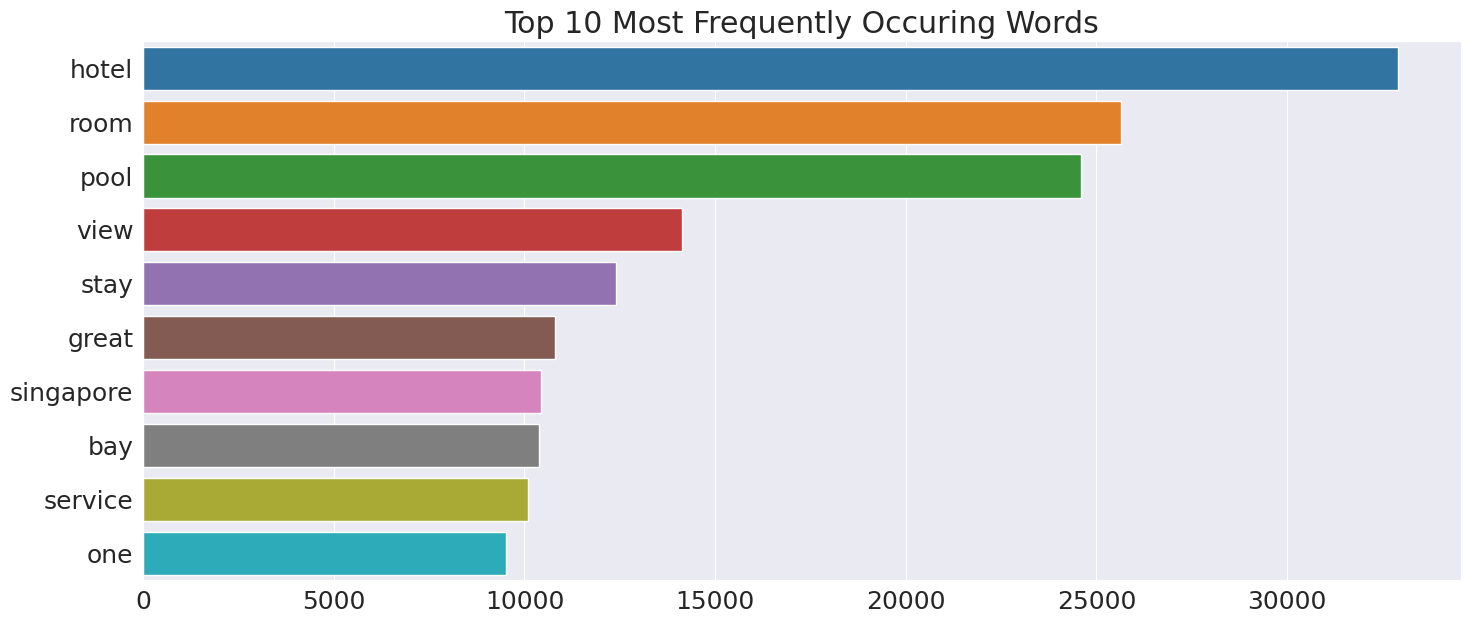

In [59]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

## Most Frequently occuring N_grams

**What is an N-gram?** <br>
An n-gram is sequence of n words in a text. Most words by themselves may not present the entire context. Typically adverbs such as 'most' or 'very' are used to modify verbs and adjectives. Therefore, n-grams help analyse phrases and not just words which can lead to better insights.
<br>
> A **Bi-gram** means two words in a sequence. 'Very good' or 'Too great'<br>
> A **Tri-gram** means three words in a sequence. 'How was your day' would be broken down to 'How was your' and 'was your day'.<br>

For separating text into n-grams, we will use `CountVectorizer` from Sklearn

In [60]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['combined_review'])

In [61]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

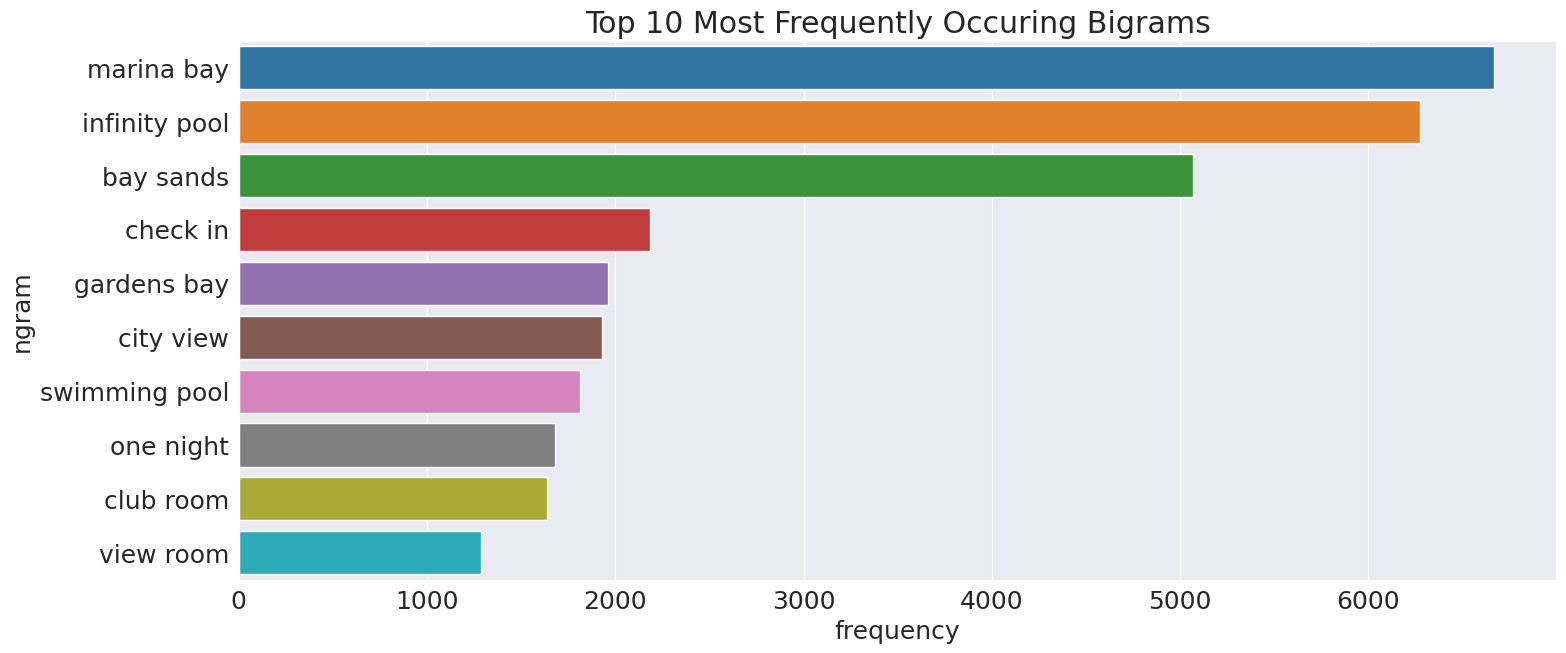

In [62]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [64]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['combined_review'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

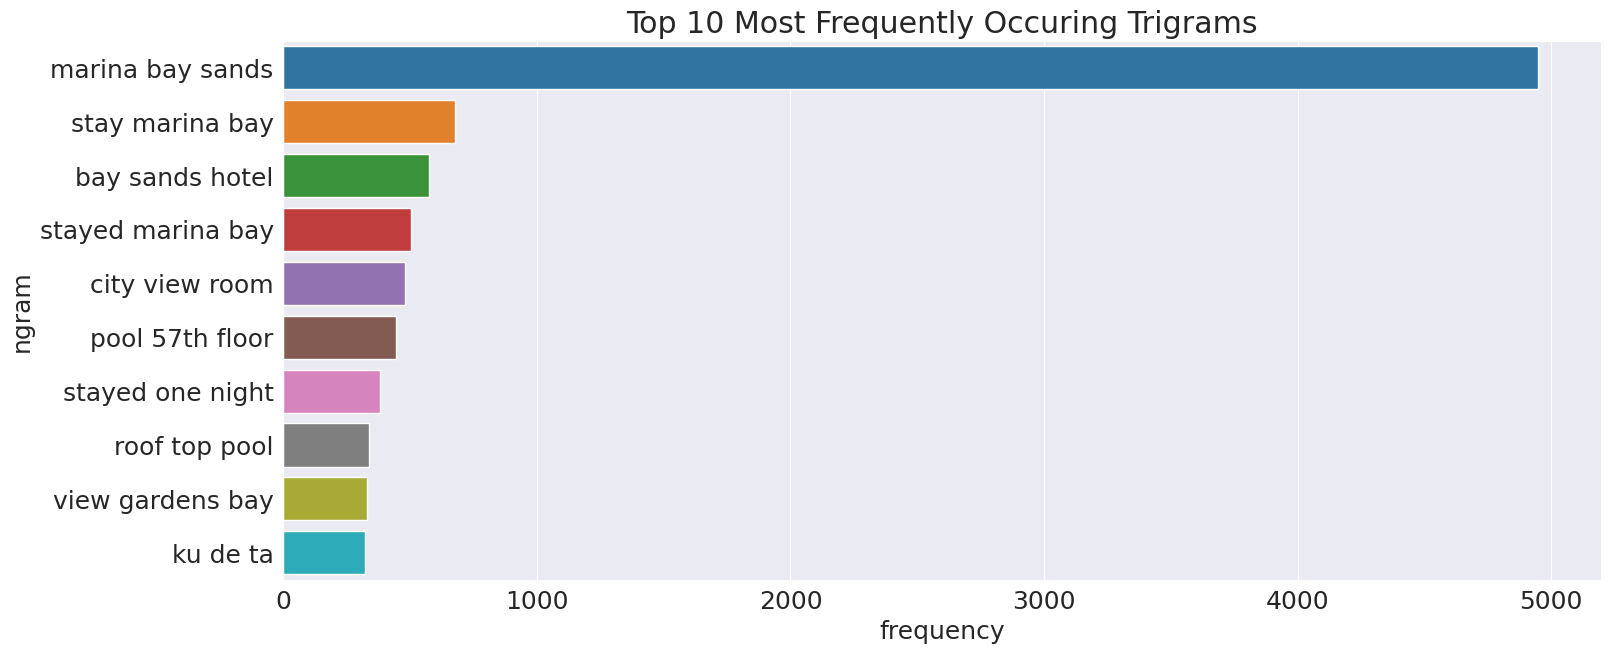

In [65]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

In [67]:
good_reviews = df[df.label == "Positive"]
bad_reviews = df[df.label == "Negative"]

In [68]:
good_reviews_text = " ".join(good_reviews.combined_review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.combined_review.to_numpy().tolist())

In [69]:
from wordcloud import WordCloud, STOPWORDS

In [70]:
stopwords = set(STOPWORDS)

# generate Word Cloud
def gen_wc(txt, cmap):
    w = ['hotel', 'room', 'rooms', 'location', 'staff', 'breakfast', 'bed', 'bathroom'] # selected words to be removed from wordcloud
    stopwords = set(STOPWORDS).union(w)

    # crisp wordcloud : https://stackoverflow.com/a/28795577/11105356
    wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords, colormap = cmap).generate(txt)
    plt.figure(figsize=(14,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

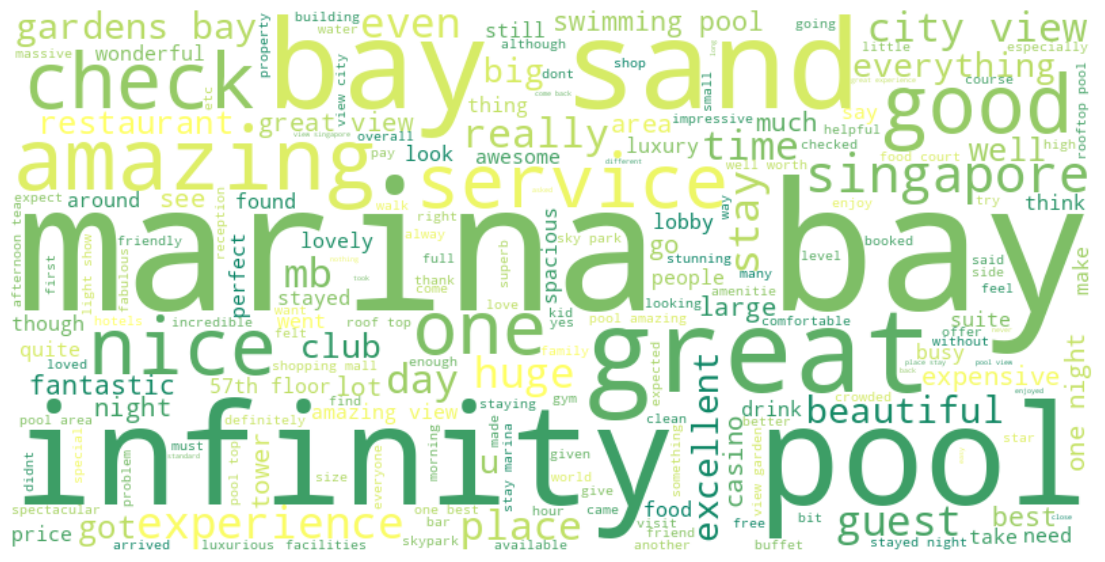

In [71]:
gen_wc(good_reviews_text, "summer")

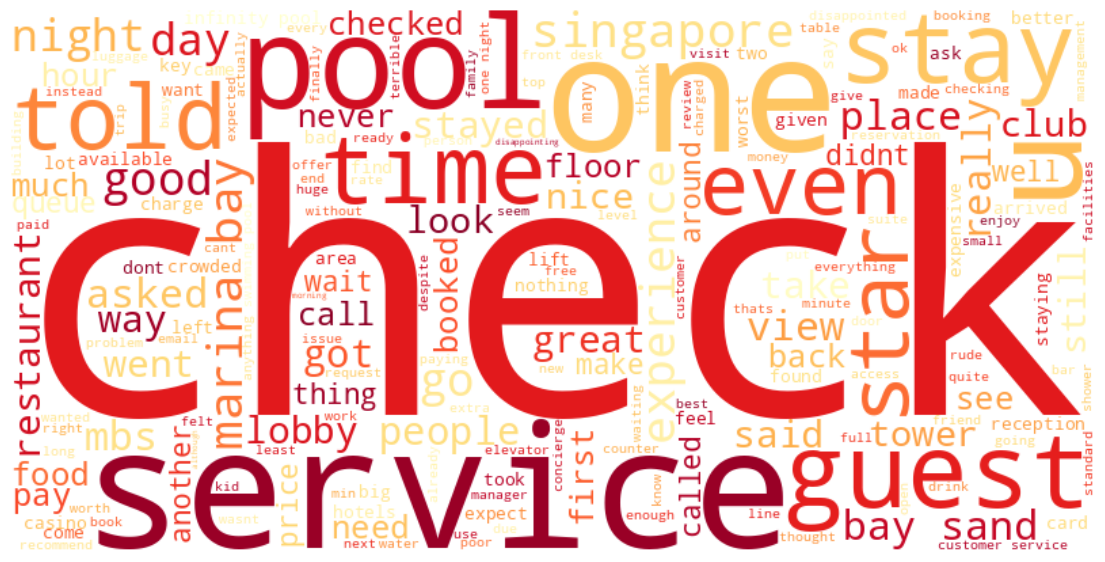

In [72]:
gen_wc(bad_reviews_text, "YlOrRd")